## Twitter and Displacement
Utilizing geotagged Twitter data from the years 2012-2016, this project seeks to test how social media data can be used as a supplement for an early warning system for neighborhood displacement due to gentrification. My research question is: **How does social media data serve as a predictor of displacement or gentrification in a given area?**

**The datasets that I have are as follow:**

1. Twitter data from 2011-2016 that has been geotagged for the Sydney Metropolitan area in Australia
2. Shapefiles for Australia that contain their census tract equivalent (Statistical Areas) boundaries
3. A typology based on the Urban Displacement Project’s Gentrification and Displacement typology for the statistical areas in Sydney for the years 2011 and 2016

**The type of analysis that I want to pursue are as follow:**

1. Perform an analysis that provides context on the intensity of tweeting within a given location
    a. First steps would be statistical areas, then to do an overarching analysis of the entire city
    b. In this manner, I will treat statistical areas as quadrats and perform kernel density estimates that will then generate a field to localize tweets

2. After the field has been estimated, I will construct a dynamic field of tweets over time
    a. While the specifics of regression have not been finalized, I am considering testing a spatial lag model, where the coefficients of neighboring census tracts will affect the betas in the census tract we are regressing on.
    
**Finally, after this analysis is complete, I intend to upload this into Github where the file will output an interactive map (hopefully).**

In [1]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.summary_stats import summary_stats

data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")

Wall time: 2.74 s


In [2]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [3]:
#read in the twitter data in box
au_twitter = pd.read_csv('C:\\Users\\emman\\box\\Twitter data\\Asia\\Sydney\\sydney.csv')

In [4]:
au_twitter.dropna(inplace=True)

In [5]:
au_twitter.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209


In [6]:
au_twitter.shape

(6450144, 14)

In [7]:
au_twitter['timestamp'] = pd.to_datetime(au_twitter['created_at'] // 1000, unit='s')
au_twitter['date'] = au_twitter['timestamp'].dt.date
au_twitter[['id', 'text', 'date','timestamp']].head()

,id,text,date,timestamp
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,2012-07-23,2012-07-23 14:31:39
1,227395003947810817,Optus在strathfield附近的基站是不是出故障了，各种network lost...,2012-07-23,2012-07-23 13:29:28
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,2012-07-23,2012-07-23 13:31:39
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,2012-07-23,2012-07-23 13:38:57
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,2012-07-23,2012-07-23 13:41:42


In [8]:
au_twitter['date'] = pd.to_datetime(au_twitter.date)

In [9]:
au_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6450144 entries, 0 to 7262132
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   created_at         float64       
 2   text               object        
 3   u_id               int64         
 4   u_name             object        
 5   u_created_at       float64       
 6   u_description      object        
 7   u_followers_count  int64         
 8   type               object        
 9   c_country          object        
 10  u_screen_name      object        
 11  u_friends_count    int64         
 12  location.lon       float64       
 13  location.lat       float64       
 14  timestamp          datetime64[ns]
 15  date               datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(4), object(6)
memory usage: 836.6+ MB


Let's give those lat long a specific geometry as a point value for later geospatial plotting

In [10]:
# Create a shapely.geometry.Point for each tweet
geometry = [Point(xy) for xy in zip(au_twitter['location.lon'], au_twitter['location.lat'])]
crs = {'init' :'epsg:4326'}

In [11]:
# Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
twt_gdf = gpd.GeoDataFrame(au_twitter, crs=crs, geometry=geometry)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
print(twt_gdf.shape)
twt_gdf.head()

(6450144, 17)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,geometry
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,POINT (151.21963 -33.87807)
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,2012-07-23 13:29:28,2012-07-23,POINT (151.08906 -33.86906)
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,POINT (150.94787 -33.79827)
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,POINT (151.17801 -33.80927)
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,POINT (151.22299 -33.91221)


C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


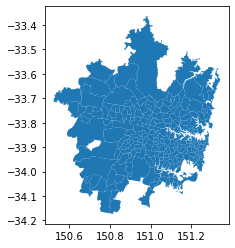

In [13]:
# Read Australia SA2 shapefiles
ucl_sa2 = gpd.read_file('C:/Users/emman/Box/Twitter data/Observation Shapefiles/syd.geojson')
# plot the UCL area
ucl_sa2.plot()
# We also need to change the crs 
ucl_sa2.crs = {'init': 'epsg:4326'}

In [14]:
twt_gdf_sample = twt_gdf.sample(100000)

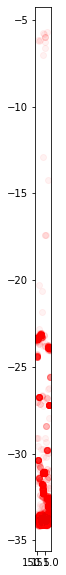

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))
ucl_sa2['geometry'].plot(ax=ax)
twt_gdf_sample.plot(ax=ax, marker='o', color='red', alpha=0.05);

Hey, that's really stupid and uninformative. Maybe there's a better way?

In [16]:
twt_gdf = gpd.sjoin(twt_gdf,ucl_sa2,how='left',op='within')

In [17]:
twt_gdf.dropna(inplace=True)

In [18]:
twt_gdf_sample = twt_gdf.sample(100000)

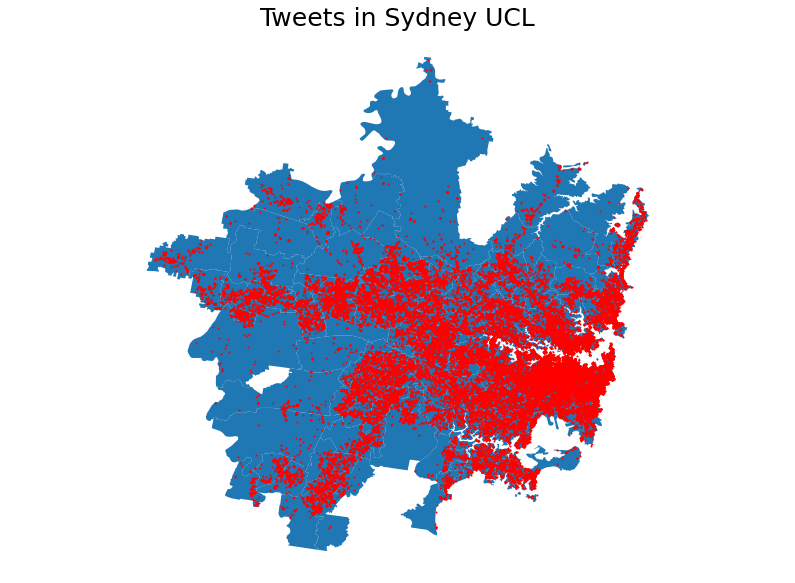

In [19]:
figure, ax = plt.subplots(figsize=(14,10))
base = ucl_sa2.plot(ax=ax)
twt_gdf_sample.plot(ax=base, markersize=1, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Sydney UCL', fontdict= 
            {'fontsize':25})

plt.show()

In [20]:
twt_gdf.drop(['index_right','SA3_CODE16','SA3_NAME16','SA4_CODE16','SA4_NAME16','GCC_CODE16','GCC_NAME16',
                'STE_CODE16','STE_NAME16', 'geometry'],
                axis=1,
                inplace=True)
twt_gdf.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,2012-07-23 13:29:28,2012-07-23,120031575,11575,Strathfield,6.4515,117.0,120031575.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"


In [21]:
# Select only users with greater than 20 tweets
df_20 = twt_gdf.groupby('u_id').filter(lambda group: len(group) > 20)

print(df_20.shape)
df_20.head()

(5540594, 26)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,2012-07-23 13:29:28,2012-07-23,120031575,11575,Strathfield,6.4515,117.0,120031575.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"


# Extract home location

## Ate's methodology for extracting home location:

1. Consider tracts satisfying the following properties:
 * More than 10 tweets total
 * Sent from more than 10 different days
 * Sent from more than 8 different hours of the day
2. Of the remaining candidates, select the tract with the most tweets



### 1a. More than 10 tweets total¶

Explanation of code below:

1. From our data
2. Group by user u_id and tract OBJECTID (assumed to be the tract ID)
3. Select only the user-tract combinations for which there are more than MIN_TWEETS tweets (i.e. for each user, select only the tracts with more than MIN_TWEETS tweets)

In [22]:
df_sample = df_20[:100000]

In [23]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    df_sample # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [24]:
print(output_1a.shape)
output_1a.head()

(82050, 26)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,2012-07-23 13:26:00,2012-07-23,126021500,11500,Macquarie Park - Marsfield,10.6720,217.0,126021500.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"


In [25]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

## 1b. Sent from more than 10 days

In [26]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

,id,text,date,timestamp
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,2012-07-23,2012-07-23 14:31:39
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,2012-07-23,2012-07-23 13:31:39
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,2012-07-23,2012-07-23 13:38:57
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,2012-07-23,2012-07-23 13:41:42
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,2012-07-23,2012-07-23 13:26:00


Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-SA2 combinations for which there are more than MIN_DAYS unique dates

In [27]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [28]:
print(output_1b.shape)
output_1b.head()

(74502, 26)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,2012-07-23 13:26:00,2012-07-23,126021500,11500,Macquarie Park - Marsfield,10.6720,217.0,126021500.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"


In [29]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

### 1c. Sent from more than 8 different hours of the day

In [30]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

,id,text,hour
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,14
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,13
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,13
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,13
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,13


Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-tract combinations for which there are more than MIN_HOURS unique hours

In [31]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [32]:
print(output_1c.shape)
output_1c.head()

(63880, 27)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types,hour
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static,14
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change",13
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static,13
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change",13
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,2012-07-23 13:26:00,2012-07-23,126021500,11500,Macquarie Park - Marsfield,10.6720,217.0,126021500.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change",13


In [33]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

## 2. Of the remaining candidates, select the tract with the most tweets

In [34]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

u_id       SA2_5DIG16
7512       11336          5
           11422         13
           11423          8
10706      11326         14
           11336         12
                         ..
778161258  11306         19
799942494  11582          7
           11583         10
803871120  11348         16
821041466  11369         33
Length: 2427, dtype: int64

It looks to be the case that there are some users that have more than one tract satisfying all three constraints specified in 1a-1c. Thus for all users, we select the most frequent tract.

Explanation of code below:

1. From our data
2. Group by user u_id and tract SA2_5DIG16
3. Find the number of observations in each user-tract combination
4. Name the resulting pd.Series count, then convert into a pd.DataFrame
5. At this point, we have a DataFrame with each row representing one user-tract combination. There are three variables: u_id, SA2_5DIG16, and count (which represents the number of tweets recorded at the user-tract combination). Sort the rows in descending order by count, so that the first row that a given u_id appears corresponds to the SA2_5DIG16 for which it has the most tweets.
6. Select the u_id and OBJECTID columns in preparation for grouping.
7. Group by u_id so that each group represents a user, and each observation inside the group is an OBJECTID. The ordering should still stay consistent with step 5, i.e. the first observation in each group corresponds to the OBJECTID at which the user tweeted the most.
8. Select that first observation, to result in the DataFrame shown below
9. Rename column for convenience
10. Convert into pd.Series for convenience

In [35]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [36]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [37]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
df_sample['home_sa2'] = df_sample['u_id'].map(home_locations.to_dict())

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# Preprocessing necessary for function
df_sample['timestamp'] = pd.to_datetime(df_sample['created_at'] // 1000, unit='s')
df_sample['date'] = df_sample['timestamp'].dt.date
df_sample['hour'] = df_sample['timestamp'].dt.hour
df_sample['SA2_5DIG16'].astype(str)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

0         11329
1         11575
2         11588
3         11399
4         11564
          ...  
134451    11310
134452    11556
134454    11336
134455    11337
134457    11603
Name: SA2_5DIG16, Length: 100000, dtype: object

In [39]:
df_sample['home_sa2'] = assign_home_location(df_sample, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
df_sample['home_sa2']

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0         117031329
1         117031337
2         125041588
3         121011399
4         118021564
            ...    
134451    116021310
134452    121011402
134454    117031336
134455    117031337
134457    128011603
Name: home_sa2, Length: 100000, dtype: object

In [40]:
df_sample['home_sa2'].isnull().sum()

19572

About 20% of our sample data is not assigned a home location; this is because that user's tweets were all filtered out in part 1a-1c. It remains to be seen how this proportion may change for the entire set of data (as opposed to the sample of 100,000 observations).

# Running the full dataset through home location code:

In [41]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 8

output_1a = (
    twt_gdf # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [42]:
print(output_1a.shape)
output_1a.head()

(4919570, 26)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,2012-07-23 13:26:00,2012-07-23,126021500,11500,Macquarie Park - Marsfield,10.6720,217.0,126021500.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"


In [43]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

In [44]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

,id,text,date,timestamp
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,2012-07-23,2012-07-23 14:31:39
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,2012-07-23,2012-07-23 13:31:39
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,2012-07-23,2012-07-23 13:38:57
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,2012-07-23,2012-07-23 13:41:42
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,2012-07-23,2012-07-23 13:26:00


In [45]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 5

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [46]:
print(output_1b.shape)
output_1b.head()

(4647888, 26)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change"
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,2012-07-23 13:26:00,2012-07-23,126021500,11500,Macquarie Park - Marsfield,10.6720,217.0,126021500.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change"


In [47]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

In [48]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

,id,text,hour
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,14
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,13
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,13
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,13
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,13


In [49]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 6

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [50]:
print(output_1c.shape)
output_1c.head()

(4511551, 27)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,timestamp,date,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types,hour
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,2012-07-23 14:31:39,2012-07-23,117031329,11329,Darlinghurst,0.8569,43.0,117031329.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static,14
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,2012-07-23 13:31:39,2012-07-23,125041588,11588,Pendle Hill - Girraween,4.4615,210.0,125041588.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change",13
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,2012-07-23 13:38:57,2012-07-23,121011399,11399,Chatswood (West) - Lane Cove North,5.5372,120.0,121011399.0,1.0,-1.0,HI - Stable Exclusion,Exclusive Static,13
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,2012-07-23 13:41:42,2012-07-23,118021564,11564,Kensington (NSW),2.6422,64.0,118021564.0,1.0,3.0,LI - Undergoing Gent/Disp,"Low Income, Undergoing Change",13
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,2012-07-23 13:26:00,2012-07-23,126021500,11500,Macquarie Park - Marsfield,10.6720,217.0,126021500.0,1.0,2.0,LI - High Risk: Gent/Disp,"Low Income, At Risk of Change",13


In [51]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

In [52]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

u_id                SA2_5DIG16
5177                11291           36
                    11302           18
                    11310           17
                    11332           13
                    11337           14
                                  ... 
767145048957825024  11568           14
777436189649309696  11444           26
780476339916713985  11314         1750
                    11329          804
                    11337         4518
Length: 52744, dtype: int64

In [53]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [54]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [55]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
twt_gdf['home_sa2'] = twt_gdf['u_id'].map(home_locations.to_dict())

In [56]:
# Preprocessing necessary for function
twt_gdf['timestamp'] = pd.to_datetime(twt_gdf['created_at'] // 1000, unit='s')
twt_gdf['date'] = twt_gdf['timestamp'].dt.date
twt_gdf['hour'] = twt_gdf['timestamp'].dt.hour

In [57]:
twt_gdf['SA2_5DIG16']= twt_gdf['SA2_5DIG16'].astype(str)

In [58]:
twt_gdf['home_sa2'] = assign_home_location(twt_gdf, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
twt_gdf['home_sa2']

MemoryError: Unable to allocate 284. MiB for an array with shape (37238861,) and data type int64

In [ ]:
twt_gdf['home_sa2'].isnull().sum()